# Tutorial on `edu-toolkit` for the TalkMoves dataset

Welcome to the tutorial on `edu-toolkit` for the [TalkMoves dataset](https://github.com/SumnerLab/TalkMoves). This tutorial will walk you through the process of using `edu-toolkit` to pre-process, annotate and analyze the TalkMoves dataset.

If you are looking for a tutorial on the individual components of `edu-toolkit`, please refer to the following tutorials to get started:
- [Text Pre-processing Colab](https://colab.research.google.com/drive/1a-EwYwkNYHSNcNThNTXe6DNpsis0bpQK)
- [Annotation Colab](https://colab.research.google.com/drive/1rBwEctFtmQowZHxralH2OGT5uV0zRIQw)
- [Analysis Colab](https://colab.research.google.com/drive/1xfrq5Ka3FZH7t9l87u4sa_oMlmMvuTfe)

This tutorial will use all of the components!

## Installation

Let's start by installing `edu-toolkit` and importing the necessary modules.


In [ ]:
!pip install git+https://github.com/rosewang2008/edu-toolkit.git


  Cloning https://github.com/rosewang2008/edu-toolkit.git to /tmp/pip-req-build-dgphjpe_
  Running command git clone --filter=blob:none --quiet https://github.com/rosewang2008/edu-toolkit.git /tmp/pip-req-build-dgphjpe_
  Resolved https://github.com/rosewang2008/edu-toolkit.git to commit 1e094c8836a3e3112cc1f996f5f12aeff013777c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.1 MB/s eta 0:00:00
  Created wheel for edu-toolkit: filename=edu_toolkit-0.0.1-py3-none-any.whl size=25946 sha256=bacc5ae8cec78f73dd6432b9a641058237be062d59c7dcfcac080e9a19077bf3
  Stored in directory: /tmp/pip-ephem-wheel-cache-a92ctwua/wheels/29/43/ec/d2472df0eb2af8f1e7d67d0710a4b3eb93fe983b15f8d7b841
  Created wheel f

In [ ]:
from edu_toolkit.preprocessors import TextPreprocessor
from edu_toolkit.annotation import Annotator
from edu_toolkit.analyzers import (
    QualitativeAnalyzer,
    QuantitativeAnalyzer,
    LexicalAnalyzer,
    TemporalAnalyzer
)
# For helping us load data
from edu_toolkit import utils

import os
import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 📑 Data

Let's download the dataset under `raw_data/`.
Note we're only download a subsample of the dataset for this tutorial; this cuts down the annotation time.
If you would like to annotate the entire dataset, feel free to upload the entire dataset to this Colab!

In [ ]:
# We will put the data here:
DATA_DIR = "raw_data"
!mkdir -p $DATA_DIR

# We will put the annotated data here:
ANNOTATIONS_DIR = "annotations"
!mkdir -p $ANNOTATIONS_DIR

# # Download the data
!wget "https://raw.githubusercontent.com/rosewang2008/edu-toolkit/master/data/talkmoves.zip"

# # Unzip the data
!unzip -n -q talkmoves.zip -d $DATA_DIR

# Data directory is then raw_data/talkmoves
DATA_DIR = "raw_data/talkmoves"

--2023-12-30 11:46:56--  https://raw.githubusercontent.com/rosewang2008/edu-toolkit/master/data/talkmoves.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346774 (339K) [application/zip]
Saving to: ‘talkmoves.zip’

talkmoves.zip       100%[===================>] 338.65K  --.-KB/s    in 0.02s   

2023-12-30 11:46:56 (17.2 MB/s) - ‘talkmoves.zip’ saved [346774/346774]



In [ ]:
# We'll set the important variables specific to this dataset. If you open one of the files, you'll see that the
# speaker and text columns are defined as:
TEXT_COLUMN = "Sentence"
SPEAKER_COLUMN = "Speaker"

# We will also define the annotation columns.
# For the purposes of this tutorial, we will only be using talktime, student_reasoning, and uptake.
TALK_TIME_COLUMN = "talktime"
STUDENT_REASONING_COLUMN = "student_reasoning"
UPTAKE_COLUMN = "uptake"

One thing that will be important is knowing how the teacher/tutor and student are represented in the dataset.
Let's load some examples and see how they are represented.

In [ ]:
files = os.listdir(DATA_DIR)
files = [os.path.join(DATA_DIR, f) for f in files if utils.is_valid_file_extension(f)]

df = utils.merge_dataframes_in_list(files)

In [ ]:
# Randomly show 10 rows
df.sample(10)

,Unnamed: 0,TimeStamp,Turn,Speaker,Sentence,Teacher Tag,Student Tag
5,NaN,NaN,1.0,T/R1,Do you remember it looks like this.,1 - None,NaN
94,94.0,NaN,49.0,T,How many of you disagree?,3 - Getting Students to Relate,NaN
53,53.0,NaN,NaN,Erik and Brian,Yeah,NaN,2 - Relating to Another Student
135,135.0,NaN,86.0,Mark,"If, if the blue was one whole, what would the ...",NaN,3 - Asking for More Information
193,193.0,NaN,85.0,T,Or the people who aren't sure want to tell us...,2 - Keeping Everyone Together,NaN
93,93.0,NaN,17.0,T,Joey?,2 - Keeping Everyone Together,NaN
34,34.0,NaN,11.0,T,I want to call the white rod one half.,1 - None,NaN
42,42.0,NaN,31.0,Alan,[Puts three light green rods on top of the blu...,NaN,5 - Providing Evidence / Explaining Reasoning
46,NaN,NaN,31.0,T/R1,Do the number names change?,2 - Keeping Everyone Together,NaN
839,839.0,NaN,481.0,T,"Okay, but why, how could she be sure?",3 - Getting Students to Relate,NaN


The students and teachers are inconsistently represented in the dataset.
Let's look at all the speakers in the dataset:

In [ ]:
speaker_names = df[SPEAKER_COLUMN].unique()

print("Speaker names: ", speaker_names)


Speaker names:  ['T' 'David' 'Meredith' 'Beth' 'Meredith and David' 'T 2' 'Danielle' 'T2'
 'Gregory' 'Michael' 'Andrew' 'Laura' 'Jessica' 'Audra' 'Kelly' 'Brian'
 'Jessica and Audra' 'SS' 'Erik' 'Mark' 'Graham' 'Others' nan 'S' 'BRYAN'
 'DANIEL' 'ANDREW' 'CYNTHIA' 'SAURABH' 'STUDENT 1' 'MS. Liu' 'JAKE'
 'ASHANK' 'Alan' 'ALYSSA' 'SN' 'KEVIN' 'SI' 'Amy' 'Jackie' 'PARTNER'
 'TIMOTHY' 'Jacquelyn' 'T/R1' 'Students' 'Student' 'LINDA FISHER'
 'DEBORAH' 'Jason' 'CHARLOTTE' 'Jeff' 'Michelle' 'Milin' 'Stephanie'
 'Stephanie & Jeff' 'Michelle & Milin' 'Blonde' 'Milin,' '~23' 'All'
 'Michelle & Jeff' 'R2' 'CECILIO DIMAS' 'STUDENT' 'Erik and Brian'
 'SAMUEL' 'OSI' 'CLAIRE']


It seems like the teacher's speaker name starts with T.
The student's speaker name are all other names.
Let's split the names into two groups: teacher and student.

In [ ]:
# Let's remove nan speakers
speaker_names = [_ for _ in speaker_names if str(_) != "nan"]

# And let's make sure the names are interpreted as strings
speaker_names = [str(_) for _ in speaker_names]

# Create a regex for the teacher names
TEACHER_START_LETTER = "T"
TEACHER_SPEAKER = [_ for _ in speaker_names if _.startswith(TEACHER_START_LETTER)]
STUDENT_SPEAKER = [_ for _ in speaker_names if _ not in TEACHER_SPEAKER]

print("Teacher speaker: ", TEACHER_SPEAKER)
print("Student speaker: ", STUDENT_SPEAKER)

Teacher speaker:  ['T', 'T 2', 'T2', 'TIMOTHY', 'T/R1']
Student speaker:  ['David', 'Meredith', 'Beth', 'Meredith and David', 'Danielle', 'Gregory', 'Michael', 'Andrew', 'Laura', 'Jessica', 'Audra', 'Kelly', 'Brian', 'Jessica and Audra', 'SS', 'Erik', 'Mark', 'Graham', 'Others', 'S', 'BRYAN', 'DANIEL', 'ANDREW', 'CYNTHIA', 'SAURABH', 'STUDENT 1', 'MS. Liu', 'JAKE', 'ASHANK', 'Alan', 'ALYSSA', 'SN', 'KEVIN', 'SI', 'Amy', 'Jackie', 'PARTNER', 'Jacquelyn', 'Students', 'Student', 'LINDA FISHER', 'DEBORAH', 'Jason', 'CHARLOTTE', 'Jeff', 'Michelle', 'Milin', 'Stephanie', 'Stephanie & Jeff', 'Michelle & Milin', 'Blonde', 'Milin,', '~23', 'All', 'Michelle & Jeff', 'R2', 'CECILIO DIMAS', 'STUDENT', 'Erik and Brian', 'SAMUEL', 'OSI', 'CLAIRE']


There are some names in the teacher list that belong to the student. Let's just manually fix that:

In [ ]:
FALSE_POSITIVE_NAMES = ["TIMOTHY"]

# Remove from the teacher speaker list
TEACHER_SPEAKER = [_ for _ in TEACHER_SPEAKER if _ not in FALSE_POSITIVE_NAMES]

# Add to the student speaker list
STUDENT_SPEAKER.extend(FALSE_POSITIVE_NAMES)

print("Teacher speaker: ", TEACHER_SPEAKER)
print("Student speaker: ", STUDENT_SPEAKER)

Teacher speaker:  ['T', 'T 2', 'T2', 'T/R1']
Student speaker:  ['David', 'Meredith', 'Beth', 'Meredith and David', 'Danielle', 'Gregory', 'Michael', 'Andrew', 'Laura', 'Jessica', 'Audra', 'Kelly', 'Brian', 'Jessica and Audra', 'SS', 'Erik', 'Mark', 'Graham', 'Others', 'S', 'BRYAN', 'DANIEL', 'ANDREW', 'CYNTHIA', 'SAURABH', 'STUDENT 1', 'MS. Liu', 'JAKE', 'ASHANK', 'Alan', 'ALYSSA', 'SN', 'KEVIN', 'SI', 'Amy', 'Jackie', 'PARTNER', 'Jacquelyn', 'Students', 'Student', 'LINDA FISHER', 'DEBORAH', 'Jason', 'CHARLOTTE', 'Jeff', 'Michelle', 'Milin', 'Stephanie', 'Stephanie & Jeff', 'Michelle & Milin', 'Blonde', 'Milin,', '~23', 'All', 'Michelle & Jeff', 'R2', 'CECILIO DIMAS', 'STUDENT', 'Erik and Brian', 'SAMUEL', 'OSI', 'CLAIRE', 'TIMOTHY']


## 📝 Text Pre-Processing and Annotation

Let's first preprocess and annotate the dataset with `edu-toolkit`. The following section will:
- Read each file in the dataset and preprocess it using `edu-toolkit`'s `Preprocessor`. We'll need to anonymize the names and merge the utterances by speaker.
- Then, annotate the file using `edu-toolkit`'s `Annotator` for talktime, student reasoning and uptake.
- Finally, save the annotated file under `data/annotated/`.

Let's get started!

In [ ]:
# First, let's create the replacement names for the teacher and student speakers
TEACHER_REPLACEMENT_NAMES = ["[TEACHER]"] * len(TEACHER_SPEAKER)

# We will replace the student names with [STUDENT_0], [STUDENT_1], etc.
# This will approximately preserve the unique identity of each student, while also anonymizing them.
STUDENT_REPLACEMENT_NAMES = [f"[STUDENT_{i}]" for i in range(len(STUDENT_SPEAKER))]


In [ ]:
# Initialize the preprocessor and annotator
processor = TextPreprocessor()
annotator = Annotator()

# This takes about 50 minutes on Colab, CPU
# Though this time varies depending on bandwidth
for filename in tqdm.tqdm(os.listdir(DATA_DIR)):
    if utils.is_valid_file_extension(filename):
        df = utils.load_data(os.path.join(DATA_DIR, filename))

    # Preprocess the data. Let's anonymize the names in the speaker column.
    df = processor.anonymize_known_names(
        df=df,
        text_column=SPEAKER_COLUMN,
        # We're going to directly replace the text in the speaker column with the anonymized text.
        target_text_column=SPEAKER_COLUMN,
        names=TEACHER_SPEAKER + STUDENT_SPEAKER,
        replacement_names=TEACHER_REPLACEMENT_NAMES + STUDENT_REPLACEMENT_NAMES
    )

    # Now let's anonymize the names in the text column.
    df = processor.anonymize_known_names(
        df=df,
        text_column=TEXT_COLUMN,
        target_text_column=TEXT_COLUMN,
        names=TEACHER_SPEAKER + STUDENT_SPEAKER,
        replacement_names=TEACHER_REPLACEMENT_NAMES + STUDENT_REPLACEMENT_NAMES
    )

    # Now let's merge the utterances of the same speaker together and directly update the dataframe.
    df = processor.merge_utterances_from_same_speaker(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        target_text_column=TEXT_COLUMN
    )

    # Now we're going to annotate the data.
    df = annotator.get_talktime(
        df=df,
        text_column=TEXT_COLUMN,
        output_column=TALK_TIME_COLUMN
    )

    df = annotator.get_student_reasoning(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=STUDENT_REASONING_COLUMN,
        # We just want to annotate the student utterances. So we're going to specify the speaker value as STUDENT_SPEAKER.
        speaker_value=STUDENT_REPLACEMENT_NAMES
    )

    df = annotator.get_uptake(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=UPTAKE_COLUMN,
        # We want to annotate the teacher's uptake of the student's utterances.
        # So we're looking for instances where the student first speaks, then the teacher speaks.
        speaker1=STUDENT_REPLACEMENT_NAMES,
        speaker2=TEACHER_REPLACEMENT_NAMES
    )

    # And we're done! Let's now save the annotated data as a csv file.
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(os.path.join(ANNOTATIONS_DIR, filename), index=False)

  0%|          | 0/30 [00:00<?, ?it/s]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf


tokenizer_config.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

  3%|▎         | 1/30 [00:30<14:37, 30.25s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
  7%|▋         | 2/30 [00:39<08:28, 18.17s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
 10%|█         | 3/30 [00:51<06:48, 15.13s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
 13%|█▎        | 4/30 [01:05<06:22, 14.70s/it]WARNING:root:Note: This model was tr

## Analysis

Now that we have annotated the dataset, let's analyze it using `edu-toolkit`'s `Analyzer`. We'll be doing the following:
- We'll use `QualitativeAnalyzer` to look at some examples of the talktime, student reasoning and uptake annotations.
- We'll use `QuantitativeAnalyzer` to look at the aggregate statistics of the talktime, student reasoning and uptake annotations.
- We'll use `LexicalAnalyzer` to compare the student and tutor's vocabulary.
- We'll use `TemporalAnalyzer` to look at the temporal trends of the talktime, student reasoning and uptake annotations.

Let's get started!!!

## 🔍 Qualitative Analysis

In [ ]:
# We're going to look at examples from the entire dataset.
qualitative_analyzer = QualitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Examples of talktime. Will show random examples from the dataset.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=TALK_TIME_COLUMN,
)

talktime: 54
>> [TEACHER]: Okay, that’s really great. Okay, you are really wonderful. We have about five more minutes where we can do some  problem solving [STUDENT_3] then put these things away. This is what  I would like you to do. I would like you to take a turn to  make a problem that will challenge your partner…

talktime: 54
>> [TEACHER]: I'm wondering which is bigger, one half or two thirds. Now  before you model it you might think in your head, before you begin  to model it what you is bigger [STUDENT_3] if so, if one is bigger, by how  much. Why don’t you work with your partner [STUDENT_3] see what you can  do.

talktime: 54
>> [TEACHER]: Let me write this  down. This, what you are saying here is so important, here. Let me  see if I can write this down. You're saying that you're calling the red,  you're giving red the number name, right? The length of the red,  right? We'll give it the number name, what did you say?

talktime: 4
>> [STUDENT_15]: I made a problem.

talktime: 4


In [ ]:
# Examples of student reasoning. Let's look at positive examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=1.0,
)

student_reasoning: 1.0
>> [STUDENT_29]: [Puts three light green rods on top of the blue rod]  There,  that would, if you look down it would equal up to a blue.

student_reasoning: 1.0
>> [STUDENT_15]: And I know that that’s half of [He points to the orange rod],  [STUDENT_3] I know that yellow is half of orange, which is ten.

student_reasoning: 1.0
>> [STUDENT_1]: one half by one sixth. Cause if you put six ones up to a whole



In [ ]:
# We can also look at negative examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=0.0,
)

student_reasoning: 0.0
>> [STUDENT_15]: You just don’t know the problem I just made up. You don’t  know the problem I made up.

student_reasoning: 0.0
>> [STUDENT_15]: I have a problem already. I have a problem. I have a  problem, remember it? If a light green, um, no, no.

student_reasoning: 0.0
>> [STUDENT_15]: I have one for you, too. [[TEACHER] [TEACHER] walks over]  I have a  problem.



In [ ]:
# Examples of uptake.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=UPTAKE_COLUMN,
    # I want to look at positive examples of uptake (uptake = 1.0)
    feature_value=1.0,
    # ... and look at the previous student utterance (show_k_previous_lines = 1).
    # This is interesting because it will show us how the teacher is responding to the student's utterance.
    show_k_previous_lines=1,
)

uptake: 1.0
[STUDENT_15]: If a light green was one third, what would be a whole?
>> [TEACHER]: What would be what?

uptake: 1.0
[STUDENT_15]: If a light green was one third, what would be a whole?
>> [TEACHER]: One, what would one be.

uptake: 1.0
[STUDENT_29]: [Puts three light green rods on top of the blue rod]  There,  that would, if you look down it would equal up to a blue.
>> [TEACHER]: Hold on, I’m a little confused. Tell me again. Six ones? You called  this one? What are you calling these?



## 📊 Quantitative Analysis

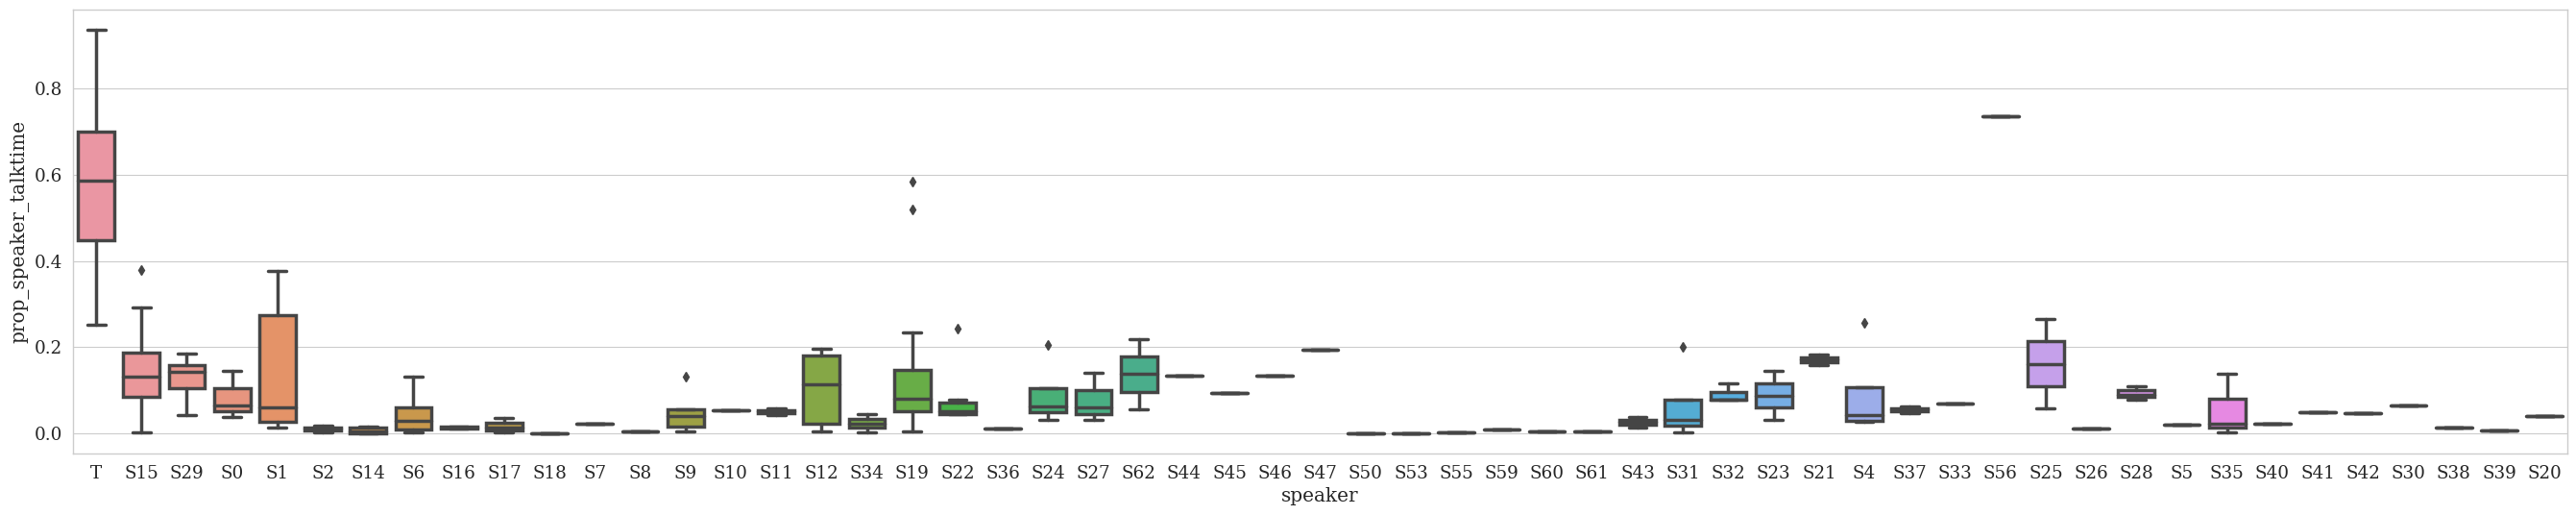

talktime

Proportion statistics
                                       count      mean       std       min       25%       50%       75%       max
speaker                                                                                                           
[STUDENT_0]                              3.0  0.082532  0.055057  0.038502  0.051667  0.064833  0.104548  0.144262
[STUDENT_10]                             1.0  0.052941       NaN  0.052941  0.052941  0.052941  0.052941  0.052941
[STUDENT_11]                             2.0  0.050219  0.010940  0.042484  0.046351  0.050219  0.054087  0.057955
[STUDENT_12]                             6.0  0.103688  0.088372  0.004112  0.022533  0.114360  0.180103  0.195356
[STUDENT_14]                             5.0  0.006621  0.006594  0.000435  0.000936  0.004612  0.012336  0.014786
[STUDENT_15]                            11.0  0.149584  0.111150  0.002649  0.083878  0.131579  0.187356  0.379571
[STUDENT_15] [STUDENT_3] [STUDENT_12]    1.0  0.

<Figure size 640x480 with 0 Axes>

In [ ]:
quantitative_analyzer = QuantitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Let's create a speaker mapping to shorten the speaker names. Teacher -> T, Student{i} -> S{i}
speaker_mapping = {
    **{_: "T" for _ in TEACHER_REPLACEMENT_NAMES},
    **{_: f"S{i}" for i, _ in enumerate(STUDENT_REPLACEMENT_NAMES)}
}

# For figure formatting because there are a lot of students
import matplotlib.pyplot as plt
plt.figure(figsize=(len(TEACHER_REPLACEMENT_NAMES + STUDENT_REPLACEMENT_NAMES)/2, 6))

# Let's plot the talk time ratio between the speakers.
quantitative_analyzer.plot_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop",
    label_mapping=speaker_mapping
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop"
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


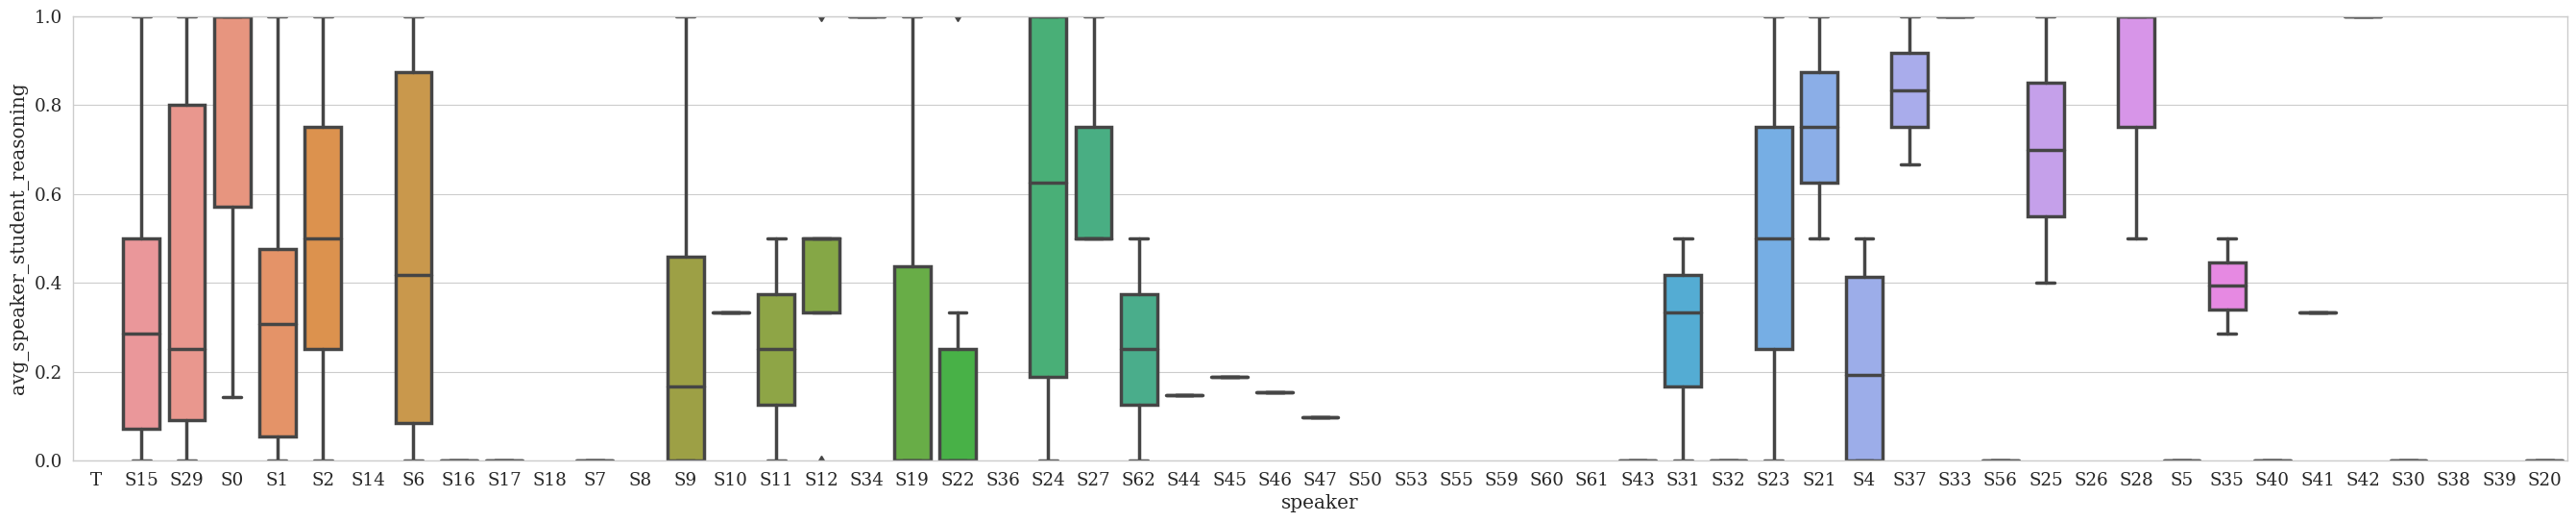

student_reasoning

Average statistics
                                       count      mean       std       min       25%       50%       75%       max
speaker                                                                                                           
[STUDENT_0]                              3.0  0.714286  0.494872  0.142857  0.571429  1.000000  1.000000  1.000000
[STUDENT_10]                             1.0  0.333333       NaN  0.333333  0.333333  0.333333  0.333333  0.333333
[STUDENT_11]                             2.0  0.250000  0.353553  0.000000  0.125000  0.250000  0.375000  0.500000
[STUDENT_12]                             5.0  0.466667  0.361325  0.000000  0.333333  0.500000  0.500000  1.000000
[STUDENT_14]                             0.0       NaN       NaN       NaN       NaN       NaN       NaN       NaN
[STUDENT_15]                             9.0  0.373016  0.363437  0.000000  0.071429  0.285714  0.500000  1.000000
[STUDENT_15] [STUDENT_3] [STUDENT_12]    0

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


<Figure size 640x480 with 0 Axes>

In [ ]:

# For figure formatting because there are a lot of students
import matplotlib.pyplot as plt
plt.figure(figsize=(len(TEACHER_REPLACEMENT_NAMES + STUDENT_REPLACEMENT_NAMES)/2, 6))

# What about the student reasoning? How often does the student use reasoning?
quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We change this to "avg" because we're now looking at within-speaker statistics.
    value_as="avg",
    # We can set the y-axis limits to [0, 1] because the student reasoning column is a binary column.
    yrange=(0, 1),
    label_mapping=speaker_mapping
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg"
)

Note, the tutor has no `student_reasoning` because we did not annotate the tutor's utterances for student reasoning.
We can easily remove the tutor from the plot by dropping na values:

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


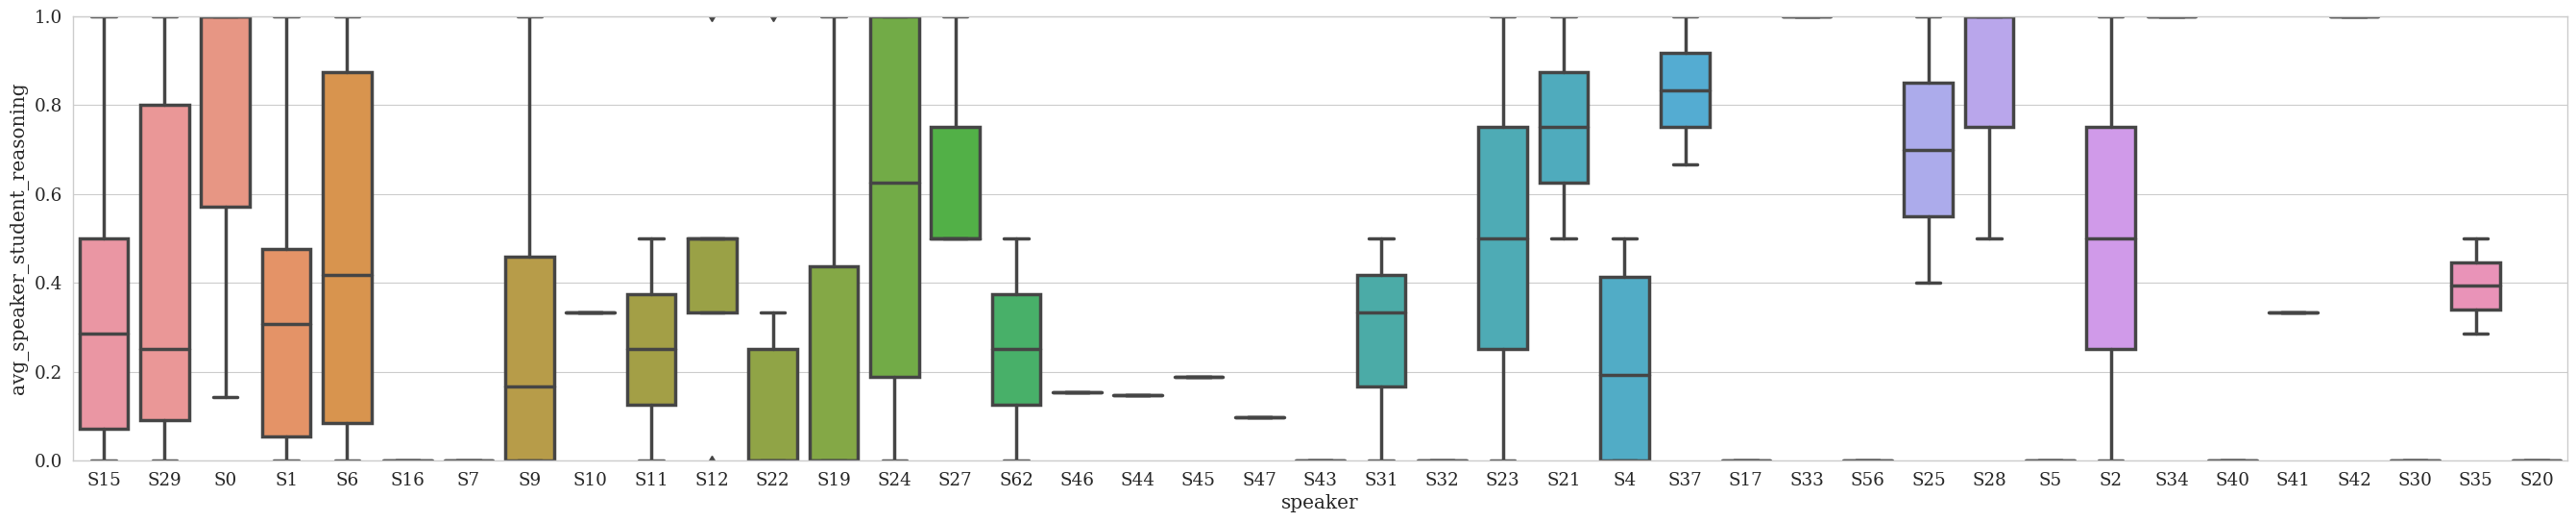

<Figure size 640x480 with 0 Axes>

In [ ]:

# For figure formatting because there are a lot of students
import matplotlib.pyplot as plt
plt.figure(figsize=(len(TEACHER_REPLACEMENT_NAMES + STUDENT_REPLACEMENT_NAMES)/2, 6))

quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True,
    label_mapping=speaker_mapping
)

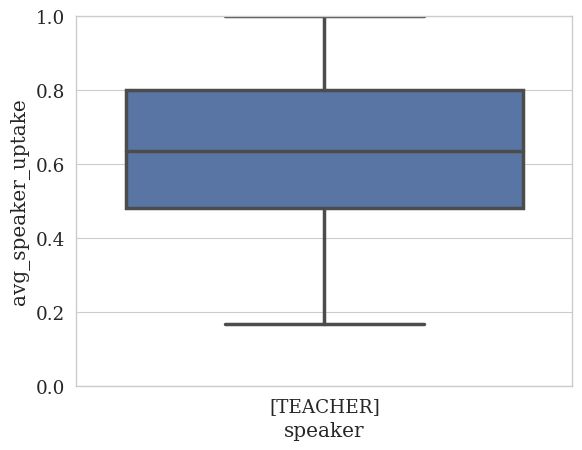

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances.
quantitative_analyzer.plot_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True
)

## 💬 Lexical Analysis

In [ ]:
lexical_analyzer = LexicalAnalyzer(data_dir=ANNOTATIONS_DIR)

# Cast as str
lexical_analyzer._df[TEXT_COLUMN] = lexical_analyzer._df[TEXT_COLUMN].astype(str)

# Let's look at the most common words per speaker in the dataset.
lexical_analyzer.print_word_frequency(
    text_column=TEXT_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We want to look at the top 10 words per speaker.
    topk=10,
    # Let's also format the text (e.g., remove punctuation, lowercase the text, etc.)
    run_text_formatting=True
)


Top Words By Speaker
[TEACHER]
student: 695
one: 343
okay: 229
think: 170
would: 134
red: 101
right: 91
want: 87
two: 83
see: 82


[STUDENT_15]
one: 75
student: 58
two: 34
green: 23
yeah: 21
would: 20
half: 20
rod: 20
three: 20
call: 20


[TEACHER] [TEACHER]
one: 13
two: 10
okay: 9
student: 9
let: 8
interesting: 6
see: 5
twelfths: 4
hear: 3
clever: 3


[STUDENT_29]
one: 28
would: 16
student: 12
green: 11
rod: 10
three: 9
considered: 9
thirds: 9
red: 7
fifth: 6


[STUDENT_0]
one: 12
would: 8
two: 6
third: 4
student: 4
put: 4
green: 4
purples: 3
three: 3
yeah: 3


[STUDENT_1]
student: 43
two: 33
one: 30
put: 17
rod: 14
rods: 13
take: 11
bigger: 11
orange: 10
yeah: 10


[STUDENT_2]
one: 4
whole: 2
third: 2
half: 1
green: 1
would: 1
blue: 1
student: 1
put: 1
three: 1


[STUDENT_1] [STUDENT_3] [STUDENT_0]
well: 1
bigger: 1
one: 1


[STUDENT_14]
yeah: 8
one: 6
sixth: 5
two: 4
yes: 3
hmm: 2
thirds: 2
twelfths: 2
red: 1
well: 1


[STUDENT_6]
one: 20
student: 16
bigger: 10
would: 10
two: 8
like

It's a bit hard to see how the student and teacher's vocabulary compare. Let's run a log-odds analysis to see which words are more likely to be used by the student or teacher.

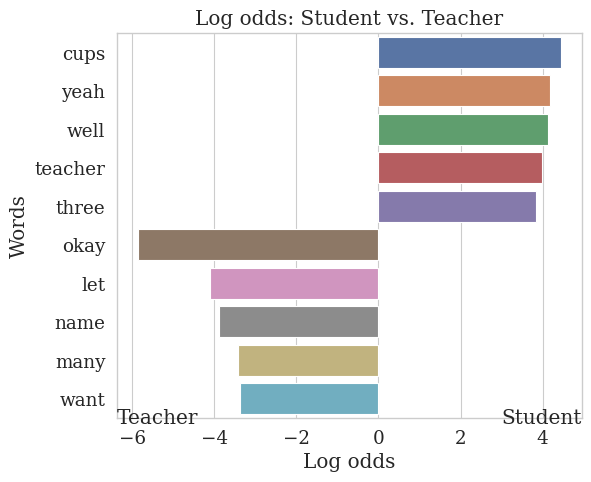

<Figure size 640x480 with 0 Axes>

In [ ]:
# This returns the merged dataframe of the annotated files in DATA_DIR.
df = lexical_analyzer.get_df()

# We want to create two groups of df: one for the student and one for the tutor.
student_df = df[df[SPEAKER_COLUMN].isin(STUDENT_REPLACEMENT_NAMES)]
teacher_df = df[df[SPEAKER_COLUMN].isin(TEACHER_REPLACEMENT_NAMES)]

# Now we can run the log-odds analysis:
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=teacher_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    # Let's name the df groups to show on the plot
    group1_name="Student",
    group2_name="Teacher",
    # Let's also run the text formatting
    run_text_formatting=True,
)


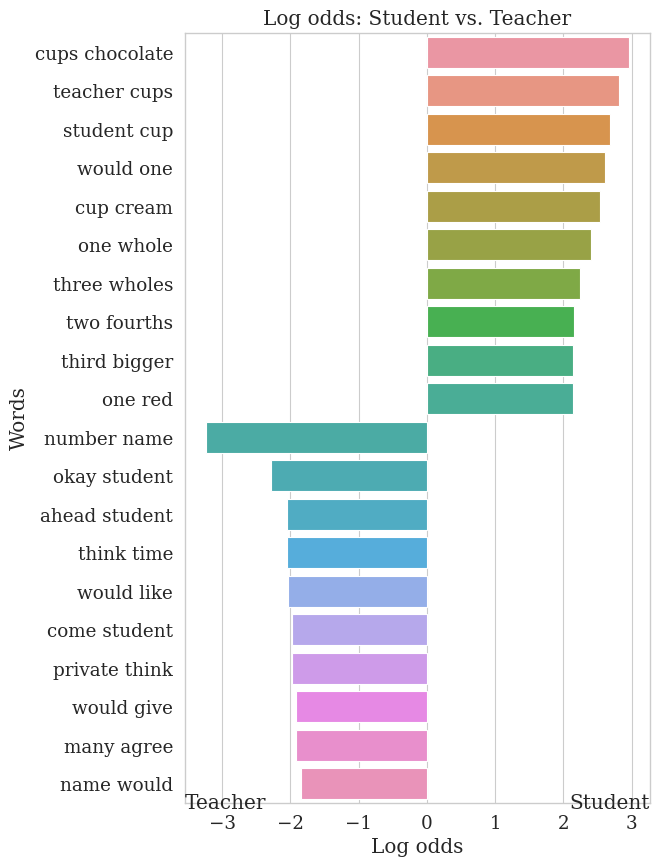

<Figure size 640x480 with 0 Axes>

In [ ]:
# We might also be interested in other n-grams. Let's look at the top 10 bigrams per speaker.
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=teacher_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    group1_name="Student",
    group2_name="Teacher",
    run_text_formatting=True,
    # n-grams:
    run_ngrams=True,
    n=2,
    topk=10,
    logodds_factor=0.5
)

## 📈 Temporal Analysis

Let's look at the temporal trends of the talktime, student reasoning and uptake annotations!

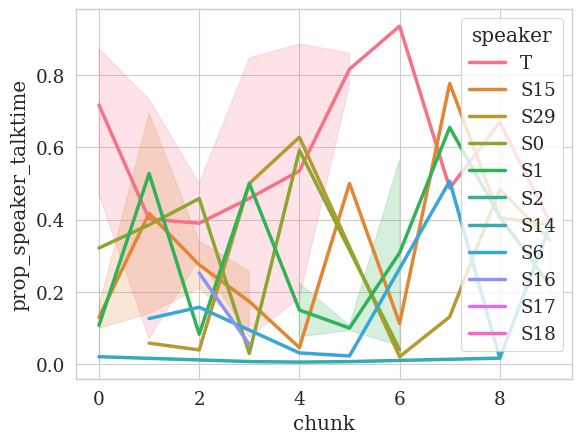

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cutting max num transcripts to 3 to show speakers
temporal_analyzer = TemporalAnalyzer(data_dir=ANNOTATIONS_DIR, max_transcripts=3)

# First let's look at the talk time ratio between the speakers over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="prop",
    # Let's create 10 bins for the x-axis.
    num_bins=10,
    label_mapping=speaker_mapping
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


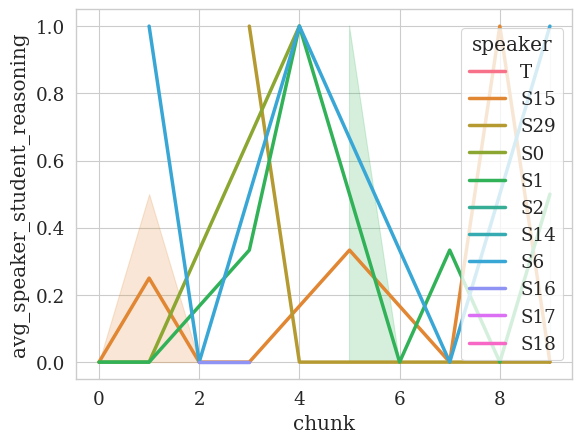

<Figure size 640x480 with 0 Axes>

In [ ]:
# Now student reasoning over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 5 bins for the x-axis.
    num_bins=10,
    label_mapping=speaker_mapping
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


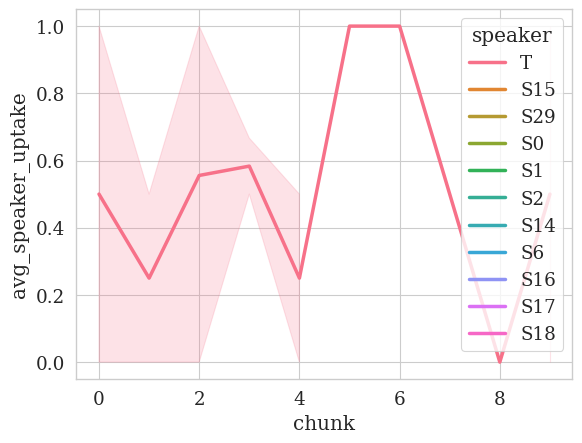

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 5 bins for the x-axis.
    num_bins=10,
    label_mapping=speaker_mapping
)

## 📚 Conclusions and Next Steps

Great! From this tutorial, we learned how to use `edu-toolkit` to preprocess, annotate and analyze the Amber dataset.
We saw how very simple principles built into `edu-toolkit` can be used to analyze the dataset and gain insights into the data from various perspectives (qualitative, quantitative, lexical and temporal).

Other resources you can check out include:
- [Tutorial on edu-toolkit for the NCTE dataset](https://colab.research.google.com/drive/1k3fn6uY4QRMtPUZN6hpMd6o-0g7fYotg)
- [Tutorial on edu-toolkit for the Amber dataset](https://colab.research.google.com/drive/1Q3anUPcemMils4cz2gwEwDdKCjEdm6T9)
- [`edu-toolkit` documentation](https://edu-toolkit.readthedocs.io/en/latest/index.html)
- [`edu-toolkit` GitHub repository](https://github.com/rosewang2008/edu-toolkit/tree/main)

If you have any questions, please feel free to reach out to us on [`edu-toolkit`'s GitHub](https://github.com/rosewang2008/edu-toolkit).

👋 Happy exploring your data with `edu-toolkit`!